In [131]:
import numpy as np, cmath,scipy as sp
import scipy.io
from matplotlib import pyplot as plt

from numpy import pi, sin, cos, exp, sqrt, log, random  #import basic functions from numpy that we'll need

%matplotlib inline

In [2]:
import seaborn as sns
sns.set_palette('muted')
sns.set_style('darkgrid')

In [8]:
data=scipy.io.loadmat('sampleEEGdata')

In [21]:
EEGdata=data["EEG"][0,0]["data"]
srate = float(data["EEG"][0,0]["srate"][0,0])

###Figure 12.1
The real component of a Morlet wavelet is a cosine multiplied by a Gaussian window:
\begin{equation}
Re(\text{Morlet wavelet}) = \cos(2\pi f t) e^{-t^2/(2s^2)}
\end{equation}

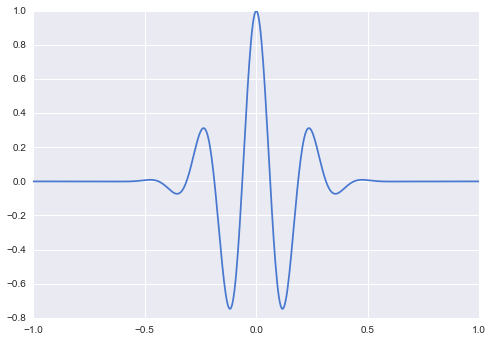

In [18]:
time = np.arange(-1,1+1/srate,1/srate)

f=4 #sinewave frequency, Hz

#create a sinewave (cosine wave)
sine_wave = cos(2*pi*f*time)

#create a Gaussian

s=4/(2*pi*f) #standard deviation

gaussian_win = exp(-time**2/(2*s**2))

#plot our first wavelet!
_=plt.plot(time,sine_wave*gaussian_win)

###Figure 12.2

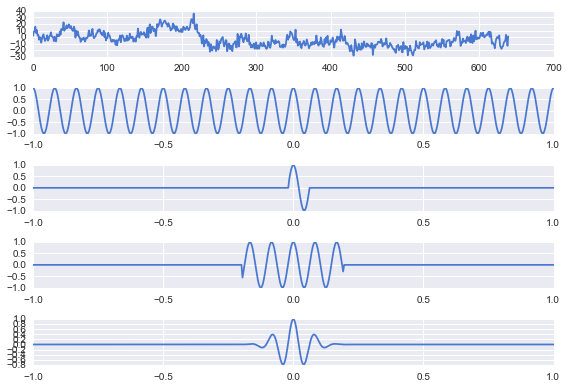

In [35]:
fig=plt.figure()

fig.add_subplot(share_x=True)

plt.subplot(511)
plt.plot(np.squeeze(EEGdata[46,:,0]))

plt.subplot(512)
sine_wave = cos(2*pi*12*time) # 12Hz cosine wave
plt.plot(time,sine_wave)

plt.subplot(513)
#boxcar envelope
boxcar = np.zeros(len(sine_wave))
midpoint = (len(time)-1)/2.
boxcar[midpoint-np.round(srate/12./5.):midpoint+np.round(srate/12./1.25)] = 1
plt.plot(time,sine_wave*boxcar)

plt.subplot(514)
#boxcar of different length
boxcar = np.zeros(len(sine_wave))
midpoint = (len(time)-1)/2.
boxcar[midpoint-50:midpoint+50] = 1
plt.plot(time,sine_wave*boxcar)

plt.subplot(515)
s = 1.5/(2*pi*f)
gaussian_win = exp(-time**2/(2*s**2))
plt.plot(time,sine_wave*gaussian_win)

plt.tight_layout()

###Figure12.3

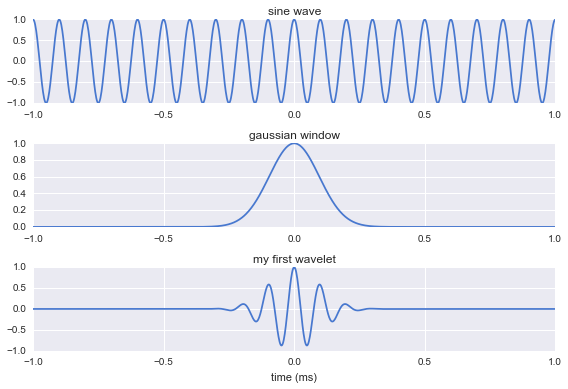

In [42]:
srate = 500. #sample rate in Hz
f = 10
time = np.arange(-1,1,1/srate)

#complex sinusoid
sine_wave = exp(2*pi*1j*f*time)

#Gaussian window
s = 6/(2*pi*f)
gaussian_win = exp(-time**2/(2*s**2))

#together they make a complex morlet wavelet!
wavelet = sine_wave*gaussian_win

#create plots for each component
fig = plt.figure()
fig.add_subplot(share_x=True)

plt.subplot(311)
plt.plot(time,np.real(sine_wave))
plt.title("sine wave")

plt.subplot(312)
plt.plot(time,gaussian_win)
plt.title("gaussian window")

plt.subplot(313)
plt.plot(time,np.real(wavelet))
plt.title("my first wavelet")
_=plt.xlabel("time (ms)")

plt.tight_layout()

###Figure 12.4

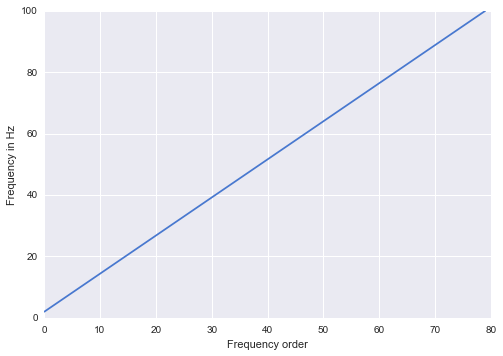

In [46]:
num_wavelets = 80 # number of frequency bands
lowest_frequency = 2 #in Hz
highest_frequency = 100 # in Hz

#(linear) equally spaced frequencies for our wavelet family
frequencies = np.linspace(lowest_frequency,highest_frequency,num_wavelets)

plt.figure()
plt.plot(frequencies)
plt.xlabel("Frequency order")
_=plt.ylabel("Frequency in Hz")

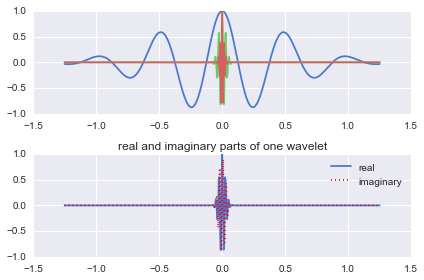

In [323]:
#initialize our wavelet family
wavelet_family = np.zeros([num_wavelets,len(time)])*1j #1j is to create a complex array of zeros

#iterate through freqs and make a wavelet family

for fi in xrange(num_wavelets):
    
    #create a sine wave
    sinewave = exp(2*1j*pi*frequencies[fi]*time)
    
    #create gaussian window
    gaus_win = exp(-time**2/(2*(6/(2*pi*frequencies[fi]))**2))
    
    #create wavelet by multiplying our sine wave by the gaussian window
    wavelet_family[fi,:] = sinewave*gaus_win
    
    #this could be accomplished on one line
#     wavelet_family[fi,:] = exp(2*1j*pi*frequencies[fi]*time) * exp(-time**2/(2*(6/(2*pi*frequencies[fi]))**2))

#plot some of our wavelet family
fig=plt.figure()
fig.add_subplot(share_x=True)
plt.subplot(211)
_=plt.plot(time,np.real(wavelet_family[::np.round(random.rand()*30),:].T))


plt.subplot(212)
plt.plot(time,np.real(wavelet_family[30,:]))
plt.plot(time,np.imag(wavelet_family[30,:]),'r:')
plt.title("real and imaginary parts of one wavelet")
plt.legend(["real","imaginary"])
plt.tight_layout()

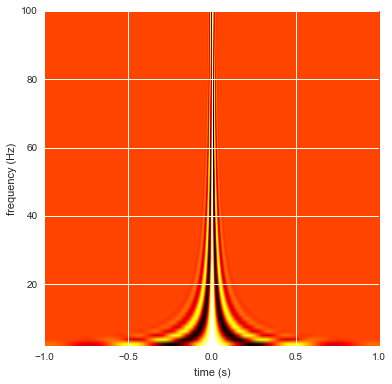

In [122]:
fig=plt.figure(figsize=(6,6))
plt.imshow(np.real(wavelet_family), 
           extent=[time[0], time[-1], frequencies[0], frequencies[-1]],
           aspect="auto",
           cmap=plt.get_cmap("hot"),
           origin="lower")

plt.xlabel("time (s)")
_=plt.ylabel("frequency (Hz)")

###Figure 12.5

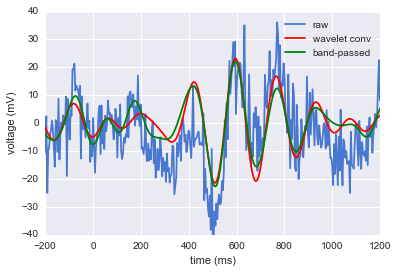

In [252]:
from numpy.fft import fft, ifft #import fft functions for ease of use
from scipy import signal as sig
#EEG data from one trial (electrode FCz)
eegdata = np.squeeze(EEGdata[46,:,9])
EEGpnts = data["EEG"][0,0]["pnts"][0,0] #number of points in EEG data
EEGtimes = data["EEG"][0,0]["times"][0]
EEGsrate = float(data["EEG"][0,0]["srate"][0])


#create wavelet
time = np.arange(-1,1 + 1/EEGsrate,1/EEGsrate)
f = 6 #frequency in Hz
sine_wave = exp(2*1j*pi*f*time)

#compute gaussian
s=4.5/(2*pi*f)
gaussian_win = exp(-time**2/(2*s**2))
#window the sinewave by a gaussian to create complex morlet wavelet
wavelet = sine_wave * gaussian_win

#half of wavelet size, useful for chopping off edges after convolution
halfwaveletsize = np.ceil(len(wavelet)/2)

#convolve with data
n_conv = len(wavelet) + EEGpnts - 1 #number of points in our convolution

fft_w = fft(wavelet,n_conv)
fft_e = fft(eegdata,n_conv)
#convolution theorem -- convolution = pointwise multiplication in frequency-space
ift = ifft(fft_e*fft_w,n_conv)*sqrt(s)/10 #sqrt(s)/20 is empirical scaling factor (sqrt(s)/10 in the book)
wavelet_conv_data = np.real(ift[halfwaveletsize: - halfwaveletsize]) #take middle portion of convolution
wavelet_conv_data = np.real(ift[halfwaveletsize:-halfwaveletsize]) #take middle portion of convolution


#create a filter to apply to data
nyquist = EEGsrate/2
transition_width = 0.2 #percent
filter_low = 4 #Hz
filter_high = 8 #Hz

ffrequencies = np.array([0 ,filter_low*(1-transition_width), 
                         filter_low, filter_high, filter_high*(1+transition_width), nyquist])/nyquist
ideal_response = np.array([0, 0, 1, 1, 0, 0])

#there doesn't seem to be a python equivalent to MATLAB's firls function,
#so I am going to use butterworth filter as a close approximation. 

b, a = sig.butter(5, np.array([filter_low*(1-transition_width),filter_high*(1+transition_width)])/nyquist,btype="bandpass")
eeg_4to8 = sig.filtfilt(b, a, eegdata, padlen=150)


plt.plot(EEGtimes,eegdata)
plt.plot(EEGtimes,wavelet_conv_data,'r')
plt.plot(EEGtimes,eeg_4to8,'g')
plt.axis([-200,1200,-40,40])
plt.xlabel("time (ms)")
plt.ylabel("voltage (mV)")
_=plt.legend(["raw","wavelet conv","band-passed"])

###Figure 12.6

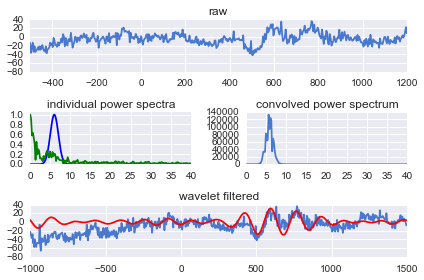

In [272]:
time = np.arange(-1,1+1/EEGsrate,1/EEGsrate)
n_conv = EEGpnts + len(time) -1
n2p1 = np.floor(n_conv/2)+1

f = 6 #hz
s = 6/(2*pi*f)
wavelet = exp(2*pi*1j*f*time) * exp(-time**2/(2*s**2))
halfwaveletsize = np.ceil(len(wavelet)/2)

eegdata = np.squeeze(EEGdata[46,:,9])

plt.figure()
plt.subplot(311)
plt.plot(EEGtimes,eegdata)
plt.xlim([-500,1200])
plt.title("raw")

plt.subplot(323)
fft_w = fft(wavelet,n_conv)
hz    = np.linspace(0,EEGsrate/2.,n2p1)
plt.plot(hz,np.absolute(fft_w[:n2p1])/np.max(np.absolute(fft_w[:n2p1])),'b')

fft_e = fft(eegdata,n_conv)
plt.plot(hz,np.absolute(fft_e[:n2p1])/np.max(np.absolute(fft_e[:n2p1])),'g')
plt.axis([0,40,0,1.05])
plt.title("individual power spectra")

plt.subplot(324)
plt.plot(hz,np.absolute(fft_e[:n2p1]*np.absolute(fft_w[:n2p1])))
plt.xlim([0, 40])
plt.title("convolved power spectrum")

plt.subplot(313)
plt.plot(EEGtimes,eegdata)
ift = ifft(fft_e*fft_w,n_conv)*sqrt(s)/10 #sqrt(s)/20 is empirical scaling factor (sqrt(s)/10 in the book)
plt.plot(EEGtimes,np.real(ift[halfwaveletsize:-halfwaveletsize]),'r')
plt.title("wavelet filtered")

plt.tight_layout()

###Figure 12.7

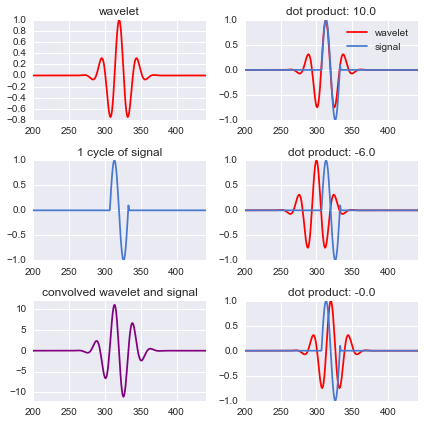

In [322]:
#create 10Hz wavelet kernel

time = np.arange(-(EEGpnts/EEGsrate/2),EEGpnts/EEGsrate/2 + 1/EEGsrate,1/EEGsrate)
f = 10. #hz
s = 4/(2*pi*f) #sd of gaussian
wavelet = cos(2*pi*f*time) * exp(-time**2/(2*s**2))

#signal is one sine cycle
timeS = np.arange(0,1/f + 1/EEGsrate,1/EEGsrate)
signal = sin(2*pi*f*timeS)

#zeropad the signal
zz = np.zeros(EEGpnts/2 - len(timeS)/2)
signal = np.concatenate([zz,signal,zz])

plt.figure(figsize=(6,6))

#plot waves
plt.subplot(321)
plt.plot(wavelet,'r')
plt.xlim(200, len(time) - 200)
plt.title("wavelet")

plt.subplot(323)
plt.plot(signal)
plt.xlim([200, len(time)-200])
plt.title("1 cycle of signal")

plt.subplot(325)
plt.plot(np.convolve(wavelet,signal,mode="same"),'purple')
plt.axis([200,len(time)-200,-12,12])
plt.title("convolved wavelet and signal")

#plot the dot products at selected phase lags
plt.subplot(322)
plt.plot(wavelet[np.round(100/f)-2-1:],'r')
plt.plot(signal)
plt.xlim([200,len(time)-200])
plt.title("dot product: " + str( np.fix(np.sum(wavelet[np.round(100/f)-2-1:]*signal[:-np.round(100/f)+3]))))
plt.legend(["wavelet","signal"])

plt.subplot(324)
plt.plot(wavelet[np.round(2.3*100/f)-2-1:],'r')
plt.plot(signal)
plt.xlim([200,len(time)-200])
plt.title("dot product: " + str( np.fix(np.sum(
                wavelet[np.round(2.3*100/f)-2-1:]*signal[:-np.round(2.3*100/f)+3]))))

plt.subplot(326)
plt.plot(wavelet,'r')
plt.plot(signal)
plt.xlim([200,len(time)-200])
plt.title("dot product: " + str( np.fix(np.sum(
                wavelet*signal))))

plt.tight_layout()